### Deep Convolutional Generative Adversarial Networks

Architecture guidelines for stable Deep Convolutional GANs
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator). 
- Usebatchnorm in both the generator and the discriminator. 
- Remove fully connected hidden layers for deeper architectures. 
- UseReLUactivation in generator for all layers except for the output, which uses Tanh. 
- UseLeakyReLU activation in the discriminator for all layers.

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
torch.set_float32_matmul_precision('high')

In [2]:
from dotenv import load_dotenv
import os

DATASET_PATH = os.environ.get('DATASET_PATH',"./data")
DATASET_PATH += "/celeba/img_align_celeba/"
BATCH_SIZE = 2048 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 1.5)

In [3]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [4]:

## Create a custom Dataset class
class CelebADataset(torch.utils.data.Dataset):
  def __init__(self, root_dir, transform=None):
    """
    Args:
      root_dir (string): Directory with all the images
      transform (callable, optional): transform to be applied to each image sample
    """

    self.root_dir = root_dir
    self.transform = transform 
    self.image_names = os.listdir(root_dir)

  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)

    return img

class Celeba(pl.LightningDataModule):
    def __init__(self, root, imgsz, batchsz, no_workers):
        super(Celeba, self).__init__()
        self.root = root
        self.imgsz = imgsz
        self.batchsz = batchsz
        self.num_workers = no_workers

        self.transform = transforms.Compose(
            [transforms.Resize(self.imgsz),
             transforms.CenterCrop(self.imgsz),
             # transforms.Grayscale(num_output_channels=1),
             # transforms.AutoAugment(), #imagenet
               
             transforms.ToTensor(),
            transforms.Normalize(mean,std)
            ]
        )

    def setup(self, stage):
        if stage == "fit" or stage is None:
            self.train_dataset = CelebADataset(
                root_dir=self.root,transform=self.transform
            )


    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batchsz,
            shuffle=True,
            num_workers=self.num_workers,
        )


In [5]:
IMAGE_SIZE = 64
ds = Celeba(DATASET_PATH,IMAGE_SIZE,BATCH_SIZE,NUM_WORKERS)

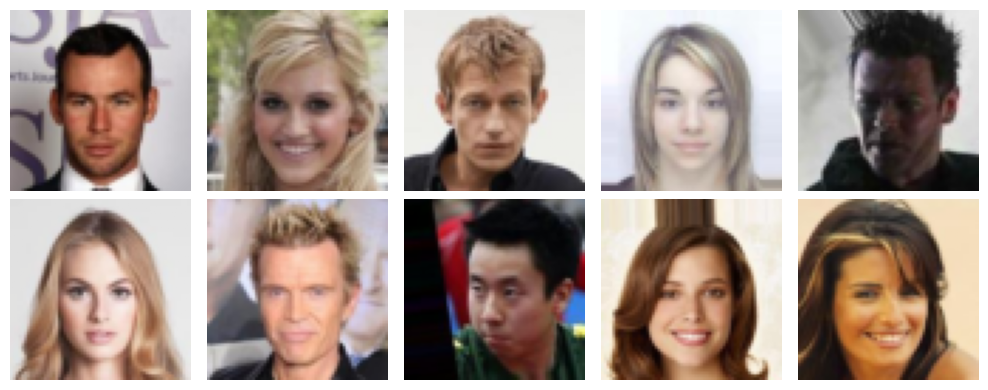

In [6]:
import matplotlib.pyplot as plt

# Sanity Check
ds.prepare_data()
ds.setup('fit')
dataloader = ds.train_dataloader()


# Create a dictionary to store one image per class
class_images = []

# Iterate over the dataset and store one image per class
for image in ds.train_dataset:

    class_images.append(image)
    if len(class_images) == 10:  # Stop after storing one image per class
        break

# Display the images from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, image in enumerate(class_images):
    ax = axes[i // 5, i % 5]
    image = (image * std.view( 3, 1, 1)) + mean.view( 3, 1, 1) 
    ax.imshow(image.permute(1,2,0))
    ax.axis('off')

plt.tight_layout()
plt.show()

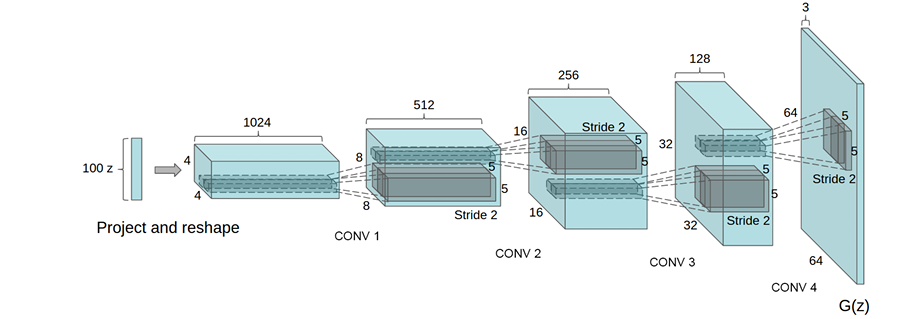

In [7]:
class Generator(nn.Module):
    def __init__(self,latent_dim,ngf,nc):
        super().__init__()
        self.g_model = nn.Sequential(*self._block(latent_dim,ngf*16,4,1,0), # N,1024,4,4
                                *self._block(ngf*16,ngf*8,4,2,1), # N,512,8,8
                                *self._block(ngf*8,ngf*4,4,2,1), # N,256,16,16
                                *self._block(ngf*4,ngf*2,4,2,1), # N,128,32,32
                                nn.ConvTranspose2d(ngf*2,nc,4,2,1,bias=False),
                                nn.Tanh())
                                
        

    def _block(self,in_channels,out_channels,kernal_size,stride,padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channels,out_channels,kernal_size,stride,padding,bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU(inplace=True))

    def forward(self,x):
            # Input : N ,latent_dim, 1,1
            return self.g_model(x.view(x.shape[0],-1,1,1))
    

In [8]:
class Discriminator(nn.Module):
    def __init__(self,input_channel,ndf):
        super().__init__()
        self.d_model =  nn.Sequential(nn.Conv2d(input_channel,ndf,4,2,1,bias=False),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     *self._block(ndf,ndf*2,4,2,1),
                                     *self._block(ndf*2,ndf*4,4,2,1),
                                     *self._block(ndf*4,ndf*8,4,2,1),
                                     nn.Conv2d(ndf*8,1,4,1,0,bias=False),
                                     nn.Sigmoid()
                                     )

    def _block(self,in_channels,out_channels,kernal_size,stride,padding):
        return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernal_size,stride,padding,bias=False),
                            nn.BatchNorm2d(out_channels),
                            nn.LeakyReLU(0.2,inplace=True))

    def forward(self,x):
        return self.d_model(x)
        

In [13]:
class DCGAN(pl.LightningModule):
    def __init__(self,latent_dim,nc,ngf,ndf,lr,b1,b2):
        super().__init__()

        self.save_hyperparameters()

        self.generator = Generator(latent_dim, ngf, nc).apply(self.weights_init)
        self.discriminator = Discriminator(nc, ndf).apply(self.weights_init)

        self.automatic_optimization = False

    def forward(self,z):
        return self.generator(z)

    def adversarial_loss(self,y_hat,y):
        return nn.functional.binary_cross_entropy(y_hat,y)

    def weights_init(self,m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

    def training_step(self,batch,batch_idx):
        imgs = batch 

        # sample noise 
        z = torch.randn(imgs.shape[0],self.hparams.latent_dim).type_as(imgs)


        # ground truth 
        label_one = torch.ones(imgs.shape[0],1,1,1).type_as(imgs)
        label_zero = torch.zeros(imgs.shape[0],1,1,1).type_as(imgs)

        # Get optimizers
        g_opt, d_opt = self.optimizers()

        # Train Generator
        self.toggle_optimizer(g_opt)

        self.generated_img = self(z)

        #log 
        if not batch_idx % 100:
            sample_imgs = self.generated_img[:6]
            grid = torchvision.utils.make_grid(sample_imgs.view(-1,self.hparams.nc,self.hparams.ngf,self.hparams.ngf))
            self.logger.experiment.add_image('generated_images',grid,self.current_epoch)
        
        g_loss = self.adversarial_loss(self.discriminator(self.generated_img),label_one)
        self.log('g_loss',g_loss,prog_bar=True)

        self.manual_backward(g_loss)
        g_opt.step()
        g_opt.zero_grad()
        self.untoggle_optimizer(g_opt)


        # Train discriminator
        self.toggle_optimizer(d_opt)
        # how well it can be label as real
        real_loss = self.adversarial_loss(self.discriminator(imgs.view(imgs.shape[0],self.hparams.nc,self.hparams.ndf,self.hparams.ndf)),label_one)
        # how well it can be label as fake
        fake_loss = self.adversarial_loss(self.discriminator(self.generated_img.detach()),label_zero)

        d_loss = (real_loss + fake_loss)/2
        self.log('d_loss',d_loss,prog_bar=True)

        self.manual_backward(d_loss)
        d_opt.step()
        d_opt.zero_grad()
        self.untoggle_optimizer(d_loss)


    def validation_step(self,batch):
        imgs, _ = batch
        validation_noise = torch.randn(8,self.hparams.latent_dim).type_as(imgs)
                    
        #log 
        sample_imgs = self(validation_noise)
        grid = torchvision.utils.make_grid(sample_imgs.view(-1,self.hparams.nc,self.hparams.ngf,self.hparams.ngf))
        self.logger.experiment.add_image('Validation_z',grid,self.current_epoch)
        

    def configure_optimizers(self):
        g_opt = torch.optim.AdamW(self.generator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])
        d_opt = torch.optim.AdamW(self.discriminator.parameters(),lr=self.hparams.lr, betas=[self.hparams.b1,self.hparams.b2])            
            
        return [g_opt,d_opt], []
    

In [14]:
nc =  3
ngf = 64
ndf = 64
latent_dim = 100
lr, b1,b2 =  2e-4, 0.5, 0.999
model = DCGAN(latent_dim, nc, ngf, ndf, lr, b1, b2)

In [16]:

logger = pl.loggers.TensorBoardLogger(save_dir='./log/', name='dcgan_calebA', version=0.1)

# saves top-K checkpoints based on "val_loss" metric
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=1,
    monitor="d_loss",
    mode="min",
    dirpath="checkpoints/"
)


trainer = pl.Trainer(min_epochs=1,logger=logger,
                        max_epochs=200 ,
                        # precision='16-mixed',
                        enable_model_summary=False,
                        callbacks=[checkpoint_callback],#,pl.callbacks.EarlyStopping('d_loss',min_delta=0.0,patience=5)],
                        enable_checkpointing  = True,
                        log_every_n_steps=10
                    )
trainer.fit(model,ds)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pranav-pc/.env/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2024-09-09 23:34:55.708991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-09 23:34:55.715893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 23:34:55.723987: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has alrea

Training: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined